In [4]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

def fix_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)
    
def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)
    
seed = 42
enable_determinism()
fix_seeds(seed)
current_dir = Path(os.getcwd())

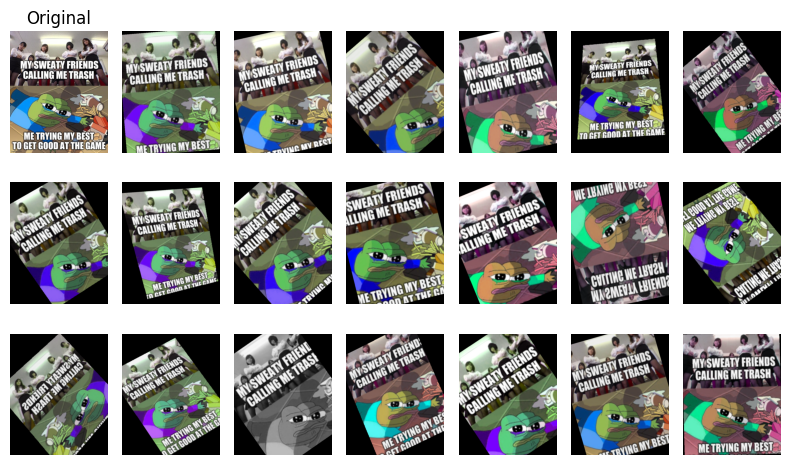

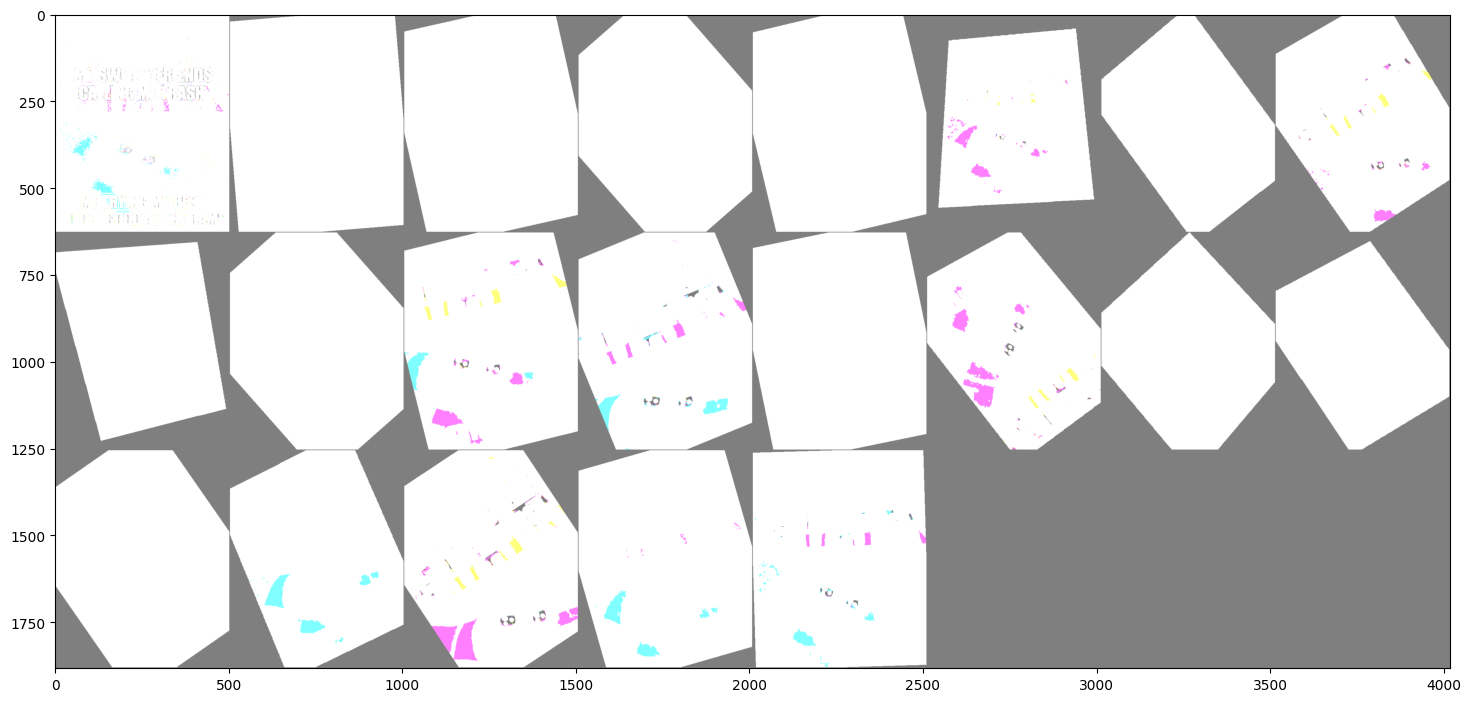

In [5]:
from PIL import Image
import torchvision.transforms as T
import torchvision

img = Image.open(current_dir / "apu.jpg").convert("RGB")

transform = T.Compose([
    T.Resize(size=256, max_size=512),
    T.RandomHorizontalFlip(p=0.1),
    T.RandomVerticalFlip(p=0.1),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.2),
    T.RandomResizedCrop(size=(img.size[1], img.size[0]), scale=(0.6,1.0)),
    T.RandomGrayscale(p=0.2),
    # T.RandomCrop(500, padding=1),
    T.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),
    T.RandomPerspective(distortion_scale=0.3, p=0.3),
    # T.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225], inplace=False),
    T.RandomRotation(degrees=(0, 45)),
    # T.ToTensor()
])

transform_to = T.Compose([
    T.PILToTensor()
])

images = []
plt.figure(figsize=(8, 5))
for i, out in enumerate([img] + [transform(img) for _ in range(20)]):
    plt.subplot(3, 7, i+1)
    plt.imshow(out)
    plt.axis("off")
    if i <= 0:
        plt.title("Original")
    images.append(out)

plt.tight_layout()

def show_img(img):
    plt.figure(figsize=(18,15))
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

show_img(torchvision.utils.make_grid([transform_to(i) for i in images]))

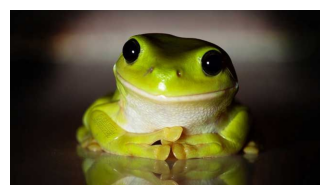

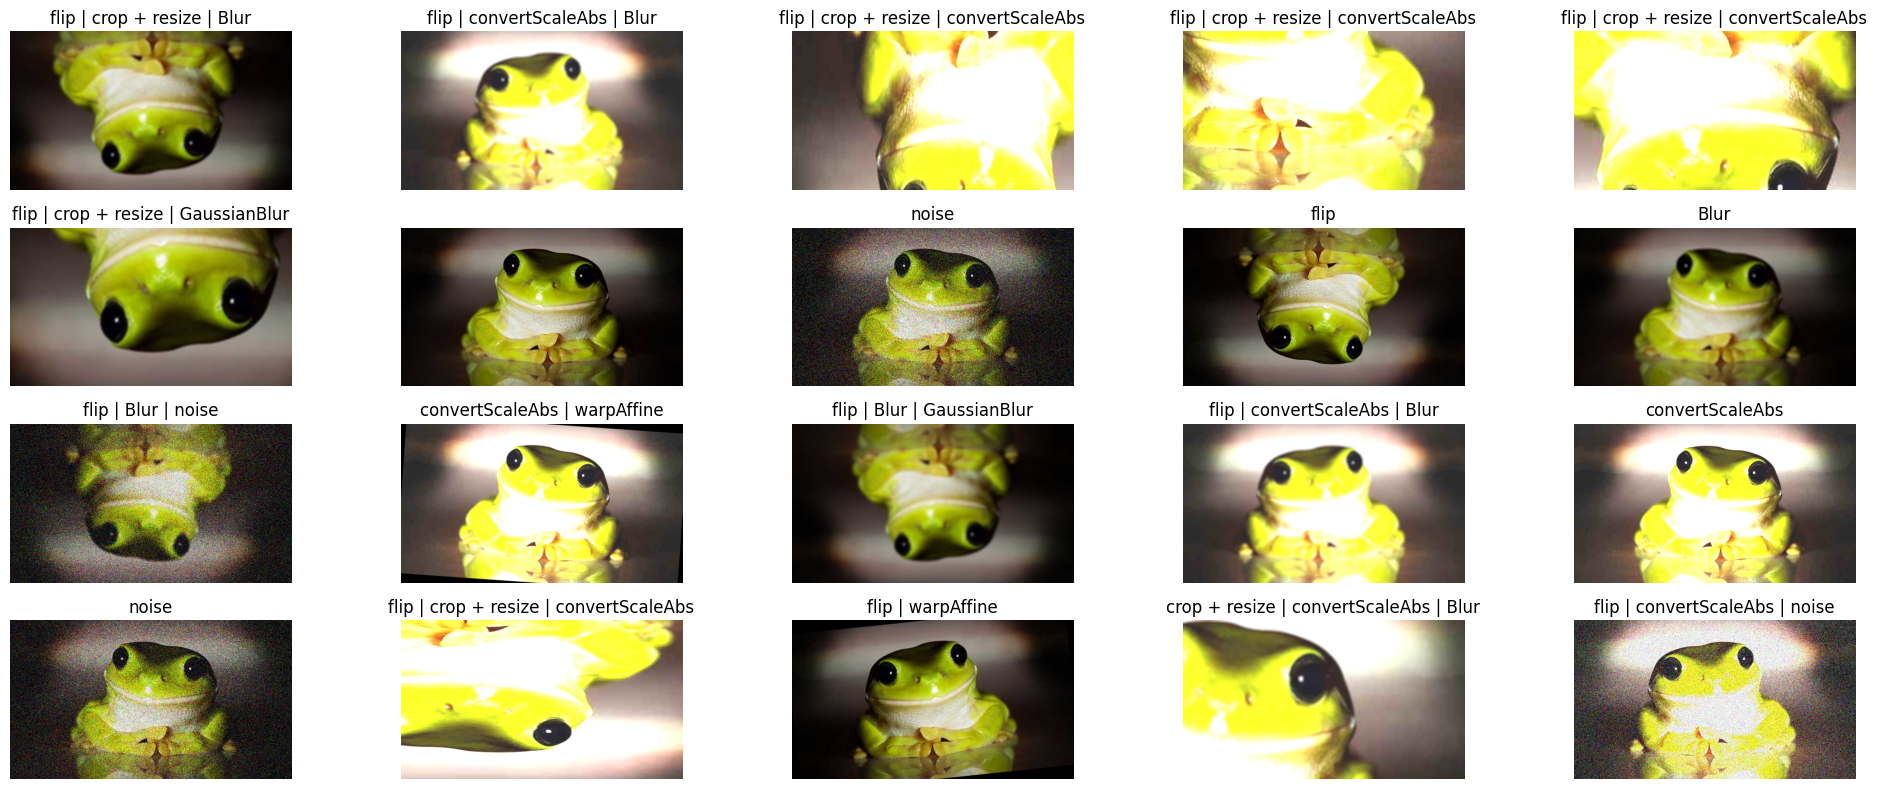

In [6]:
import cv2

img = cv2.imread(str(current_dir) + '/frog.jpg')
if img is None:
    raise FileExistsError()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(img)

def func(img: cv2.typing.MatLike, p: float) -> tuple[cv2.typing.MatLike, list[str]]:
    rows, cols = img.shape[:2]
    out_str: list[str] = []
    count = 3
    # --- Отражения ---
    if p > random.random() and count:
        img = cv2.flip(img, random.randint(-1, 1))
        out_str.append("flip")
        count -= 1
    # --- Кроп + ресайз ---
    if p > random.random() and count:
        y1 = random.randint(0, rows // 2)
        y2 = random.randint(y1 + rows // 3, rows)
        x1 = random.randint(0, cols // 2)
        x2 = random.randint(x1 + cols // 3, cols)
        crop = img[y1:y2, x1:x2]
        if crop.size <= 0:
            out_str.append("crop_failed")
        else:
            img = cv2.resize(crop, dsize=(cols, rows))
            out_str.append("crop + resize")
        count -= 1
    # --- Яркость и контраст ---
    if p > random.random() and count:
        img = cv2.convertScaleAbs(img, alpha=2, beta=40)
        out_str.append("convertScaleAbs")
        count -= 1
    # --- Блюр ---
    if p > random.random() and count:
        img = cv2.blur(img, (7,7))
        out_str.append("Blur")
        count -= 1
    # --- Гауссов блюр ---
    if p > random.random() and count:
        img = cv2.GaussianBlur(img, (7,7), sigmaX=3)
        out_str.append("GaussianBlur")
        count -= 1
    # --- Шум (Гауссов) ---
    if p > random.random() and count:
        noise = np.zeros_like(img, dtype=np.int16)
        cv2.randn(noise, (0, 0, 0), (50, 50, 50))
        out = cv2.add(img.astype(np.int16), noise)
        img = np.clip(out, 0, 255).astype(np.uint8)
        out_str.append("noise")
        count -= 1
    # --- Умножение каналов ---
    if p > random.random() and count:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img)
        h += np.random.randint(0, 100,size=(rows, cols), dtype=np.uint8 )
        s += np.random.randint(0, 20,size=(rows, cols), dtype=np.uint8 )
        v += np.random.randint(0, 10,size=(rows, cols) , dtype=np.uint8 )
        img = cv2.merge([h,s,v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        out_str.append("HSV")
        count -= 1
    # --- Повороты ---
    if p > random.random() and count:
        rand_angle = random.randint(-45,45)
        M = cv2.getRotationMatrix2D((cols//2, rows//2), rand_angle, 1)
        img = cv2.warpAffine(img, M, (cols, rows))
        out_str.append("warpAffine")
        count -= 1
    return img, out_str

nrows, ncols = 4, 5
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):
        out, prnt = func(img, random.random())
        axis[i][j].imshow(out)
        axis[i][j].axis('off')
        axis[i][j].set_title(" | ".join(prnt))
        
plt.tight_layout()

e:\PythonPortable\_env\port\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1236601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imsh

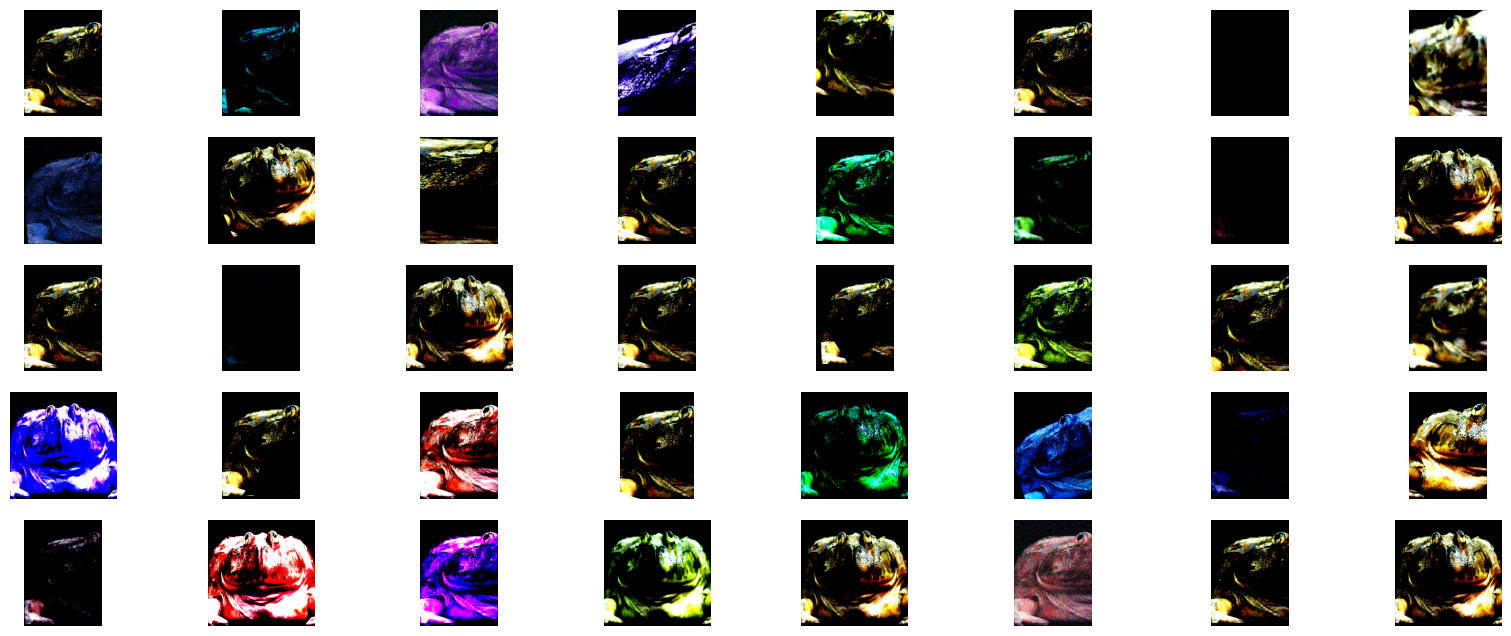

In [7]:
import albumentations as A

transform = A.Compose([
    A.Resize(height=512, width=512, p=0.1),
    A.Rotate(limit=20, p=0.1),
    A.HorizontalFlip(p=0.1),
    A.RandomShadow(p=0.1),
    A.RandomFog(p=0.1),
    A.RandomGamma(p=0.1),
    A.GaussianBlur(p=0.1),
    A.Perspective (scale=(0.00, 0.3), p=0.1),
    A.GaussNoise((.1, .25), p=0.1),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.7),
    A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.1, 
                           rotate_limit=30, 
                           p=0.1),  
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.5),
    ], p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]) 

img = cv2.imread(str(current_dir) + '/frog2.jpg')
if img is None:
    raise FileExistsError()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

nrows, ncols = 5, 8
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 8))

for i in range(nrows):
    for j in range(ncols):
        axis[i][j].imshow(transform(image=img)["image"])
        axis[i][j].axis('off')